### Import Dataset

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# funtions to handle labels
from utils.handle_labels import get_tag_counts_and_labels
from utils.handle_labels import drop_labels
from utils.handle_labels import group_labels
from utils.handle_labels import categories_count
from utils.handle_labels import get_imbalance
from utils.handle_labels import label_distribution
from utils.handle_labels import number_of_labels
from utils.message_preprocess import message_processing
# plot untils funcion
from utils.plot_utils import pie_plot

In [10]:
df = pd.read_csv('data/commit_data_new.csv')
print(df.shape)

# convert string to list
from ast import literal_eval

df['categories'] = df['categories'].apply(lambda x: literal_eval(x))
print(type(df['categories'].values[0]))
print(df['categories'].values[0])
df = df.drop(['Unnamed: 0'], axis = 1)
df.head()

(1922, 28)
<class 'list'>
['Testing', 'Bug fix']


,project name,Commit ID,commit_message,Maintenance,Testing,Feature Add,Bug fix,Documentation,Clean up,Build,...,Module Remove,Module Move,Rename,Versioning,Merge,Initialization,Internationalization,Data,Module Add,categories
0,apache-avro,126e9769f45f978f42321c4fc465198982df482b,AVRO-906. Java: Fix so that ordering of schema...,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"[Testing, Bug fix]"
1,apache-avro,2df0775d2f368b326e3ac6442ce4850e3fe62edc,AVRO-2003: Report specific location of schema ...,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[Testing, Maintenance]"
2,apache-avro,a39e6deea243dcd9a09df8f67af724003dec1d02,AVRO-1099. Java: Fix JsonDecoder to permit flo...,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"[Testing, Bug fix]"
3,apache-avro,2020c8a8cc19c58eaef2d9de75260e7341099038,AVRO-1046. Java: Fix ReflectDatumReader to be ...,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"[Testing, Maintenance, Bug fix]"
4,apache-avro,fa0059c55a31813634188eb85e53b68e33644489,AVRO-607: Java: Make SpecificData schema cache...,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"[Maintenance, Bug fix]"


### Tags Preprocessing

Maintenance : 891
Feature Add : 330
Bug fix : 266
Documentation : 237
Clean up : 192
Refactoring : 111
Indentation : 48
Token Replace : 40
Source Control : 30
Cross : 24
Legal : 18
Debug : 10
Module Remove : 6
Module Move : 5
Rename : 5
Versioning : 4
Merge : 3
Initialization : 2
Internationalization : 1
Data : 1
Module Add : 1
1    1625
2     226
3      35
4       7
5       3
dtype: int64


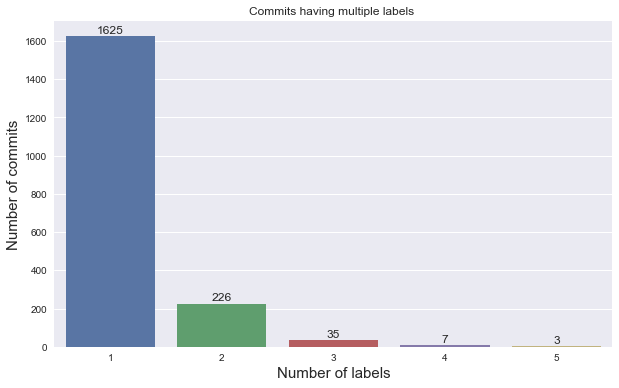

Corrective : 266
Adaptive : 239
Perfective : 1130
Implementation : 334
Non_functional : 70
Other : 34


In [11]:
# drop testing and build
new_df = drop_labels(df, ['Testing', 'Build'])
_ , target_col = get_tag_counts_and_labels(new_df)
multi_count = number_of_labels(new_df, target_col)

def group_labels_new(df, labels_to_group, new_label):
    '''
    Group some of labels

    Args:
        df - dataframe
        labels_to_group -  List of labels you want to group
        new_label -  string - new label name of grouped labels

    Returns:
        new_df - dataframe after grouped
    '''
    new_df = df.copy()

    # generate new labels by group labels
    def create_new_label(row, labels):
        new_label = 0  # initialize new label
        for label in labels:
            if row[label] == 1:
                new_label = 1  # if one of labels in grouped labels is 1 the new label is 1
        return new_label

    new_df[new_label] = df.apply(lambda row: create_new_label(row, labels_to_group), axis=1)

    # generate list of new_categories

    return new_df

new_df = group_labels_new(new_df, ['Bug fix'], 'Corrective')
new_df = group_labels_new(new_df, ['Internationalization', 'Documentation','Data'], 'Adaptive')
new_df = group_labels_new(new_df, ['Clean up', 'Indentation','Maintenance','Module Move','Module Remove','Refactoring'], 'Perfective')
new_df = group_labels_new(new_df, ['Initialization', 'Feature Add','Module Add','Internationalization'], 'Implementation')
new_df = group_labels_new(new_df, ['Legal', 'Module Remove','Rename','Token Replace','Merge'], 'Non_functional')
new_df = group_labels_new(new_df, ['Cross','Debug'], 'Other')

target_col = ['Corrective','Adaptive','Perfective','Implementation','Non_functional','Other']
multi_count = categories_count(new_df, target_col)

Corrective : 266
Adaptive : 239
Perfective : 1130
Implementation : 334
1    1635
2     148
0     101
3      10
4       2
dtype: int64


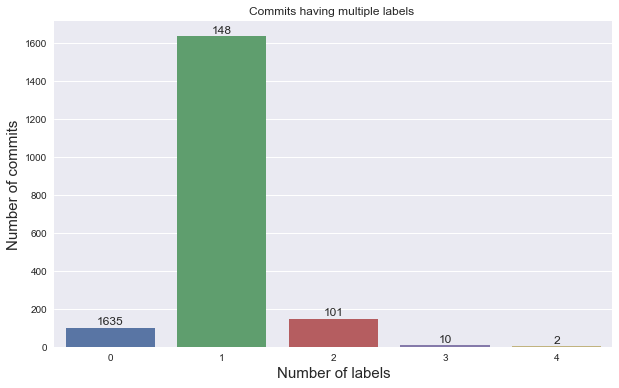

current number of samples: 1896
number of samples after drop:1635


In [12]:
# Drop 'Non-functional' and 'Other'

new_df = new_df.drop(['Non_functional','Other'],axis = 1)

target_col = ['Corrective','Adaptive','Perfective','Implementation']
multi_count = categories_count(new_df, target_col)

# Drop rows with multiple labels
target_col = ['Corrective','Adaptive','Perfective','Implementation']
multi_count = number_of_labels(new_df, target_col)

print('current number of samples: %d'%new_df.shape[0])
new_df['label_sum'] = new_df[target_col].sum(axis=1)
new_df = new_df[new_df['label_sum']==1].reset_index(drop=True)
print('number of samples after drop:%d'%new_df.shape[0])
new_df = new_df.drop(['label_sum'], axis = 1)

# Drop target col
new_df = new_df[new_df['Corrective']!=1].reset_index(drop=True)
target_col = ['Adaptive','Perfective','Implementation']

# form target cols
new_df = new_df.drop('categories', axis = 1)
new_df['target_class'] = np.argmax(new_df[target_col].values, axis = 1)

### Message Preprocessing

In [13]:
message_array = message_processing(new_df.commit_message, remove_noise=True)
print(message_array[0:10])
new_df.commit_message = message_array

['report specif locat schema incompat close', 'improv deal', 'claus support one row per match row per match close apach calcit', 'make constructor public close apach calcit', 'aggreg function one paramet like fact type factori field see necessari method take type factori argument consid chang futur close apach calcit', 'upgrad includ fix cast string add part fraction valu replac use', 'lattic creat materi demand', 'unnecessari check', 'remov inaccur', 'fix incorrect indent thank close']


### TD-IDF and Machine Learning

In [14]:
from scipy import sparse as sp_sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB

def print_evaluation_scores(y_test, predicted):
    
    print('Accuracy:', accuracy_score(y_test, predicted))
    print('F1-score macro:', f1_score(y_test, predicted, average='macro'))
    print('F1-score micro:', f1_score(y_test, predicted, average='micro'))
    print('F1-score weighted:', f1_score(y_test, predicted, average='weighted'))

In [79]:
def tfidf_features(X):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test, and val sets and return the result
    
    
    tfidf_vectorizer = TfidfVectorizer(min_df=0, max_df=1.0, ngram_range=(1, 2),token_pattern='(\S+)')
    
    X = tfidf_vectorizer.fit_transform(X)
    
    return X,tfidf_vectorizer.vocabulary_

X = new_df['commit_message'].values
y = new_df['target_class'].values
X_tfidf, tfidf_vocab = tfidf_features(X)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.1, random_state=42)

print('X train shape : ', X_train.shape)
print('X test shape : ', X_test.shape)

X train shape :  (1269, 10237)
X test shape :  (141, 10237)


### Logistic Regression

In [80]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)

y_pre_test = clf.predict(X_test)
predictions = clf.predict_proba(X_test) 
print_evaluation_scores(y_test, y_pre_test)

Accuracy: 0.7092198581560284
F1-score macro: 0.41375018458747337
F1-score micro: 0.7092198581560284
F1-score weighted: 0.6234348216582037


#### Logistic Regression with Regularization

In [73]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

def td_idf_model(df, target_columns, classifier, parameters, multi = False):

    X, y = df['commit_message'].values, df[target_columns].values
    
    # td-idf
    tfidf_vectorizer = TfidfVectorizer(max_df = parameters['max_df'],
                                       min_df = parameters['min_df'],
                                       max_features = parameters['max_features'],
                                       ngram_range=parameters['ngram'],
                                       norm=parameters['norm'],
                                       binary = parameters['binary'],
                                       use_idf = parameters['use_idf'],
                                       smooth_idf = parameters['smooth_idf'],
                                       sublinear_tf = parameters['sublinear_tf'])
    
    X_tfidf = tfidf_vectorizer.fit_transform(X)
    tfidf_vocab = tfidf_vectorizer.vocabulary_
    tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}
    
    # splite test and trainset
    X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=parameters['split_size'], random_state=42)
    print(X_train.shape)
    
    # model
    if multi == False:
        ovr = OneVsRestClassifier(classifier)
        classifier_tfidf =ovr.fit(X_train, y_train)
    else:
        classifier_tfidf = classifier.fit(X_train, y_train)
    
    #print(classifier)
        
    y_pred = classifier_tfidf.predict(X_test)

    print_evaluation_scores(y_test, y_pred)

parameters = {'max_df':1.0, 'min_df':0.0, 'ngram':(1,2), 'max_features':None, 'norm':'l2', 
              'binary': False,'use_idf':True, 'smooth_idf':True, 'sublinear_tf':False, 
              'split_size':0.1,'lr_penalty':'l1', 'lr_C':6.5, 'l1ratio':None, 'lr_maxiter':5000, 'lr_class_weight':None}

 

    
lr = LogisticRegression(penalty=parameters['lr_penalty'], C=parameters['lr_C'], solver='saga', l1_ratio = parameters['l1ratio'], 
                            random_state=0, max_iter=parameters['lr_maxiter'], class_weight=parameters['lr_class_weight'])
    
td_idf_model(new_df, 'target_class', lr, parameters)

(1269, 10144)
Accuracy: 0.6950354609929078
F1-score macro: 0.44329143623261275
F1-score micro: 0.6950354609929078
F1-score weighted: 0.630797899083256


#### Logsitic Regression One VS Rest Classifier

In [42]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr').fit(X_train, y_train)

y_pre_test = clf.predict(X_test)
predictions = clf.predict_proba(X_test) 
print('Accuracy is:',clf.score(X_test, y_test))
print(f1_score(y_test, y_pre_test, average='macro'))

clf = LogisticRegression(penalty='l1',
                         random_state=0,
                         solver='saga',
                         n_jobs=-1,
                         max_iter=1000,
                         multi_class='ovr').fit(X_train, y_train)

y_pre_test = clf.predict(X_test)
test_prob = clf.predict_proba(X_test)
train_prob = clf.predict_proba(X_train)
print('Accuracy is:',clf.score(X_test, y_test))
print(f1_score(y_test, y_pre_test, average='macro'))

Accuracy is: 0.6879432624113475
0.32621082621082625
Accuracy is: 0.6950354609929078
0.39407569141193594


### SVM

In [81]:
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV

#Libraries to Build Ensemble Model : Random Forest Classifier 
# Create the parameter grid based on the results of random search 
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5], 'C': [1, 5, 10, 20, 50, 100, 200, 500, 1000, 5000], 'decision_function_shape':['ovo','ovr']},
               {'kernel': ['linear'], 'C': [1, 5, 10, 20, 50, 100, 200, 500, 1000, 5000], 'decision_function_shape':['ovo','ovr']}]

svm_model = GridSearchCV(SVC(), params_grid, cv=5)
svm_model.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [1, 5, 10, 20, 50, 100, 200, 500, 1000, 5000],
                          'decision_function_shape': ['ovo', 'ovr'],
                          'gamma': [0.1, 0.01, 0.001, 0.0001, 1e-05],
                          'kernel': ['rbf']},
                         {'C': [1, 5, 10, 20, 50, 100, 200, 500, 1000, 5000],
                          'decision_function_shape': ['ovo', 'ovr'],
                          'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
            

In [82]:
# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 
print('Best parameters for training data:',svm_model.best_params_,'\n')

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

final_model = svm_model.best_estimator_
Y_pred = final_model.predict(X_test)
print_evaluation_scores(y_test, Y_pred)

Best score for training data: 0.7226162332545312 

Best parameters for training data: {'C': 50, 'decision_function_shape': 'ovo', 'gamma': 0.1, 'kernel': 'rbf'} 

Best C: 50 

Best Kernel: rbf 

Best Gamma: 0.1 

Accuracy: 0.7446808510638298
F1-score macro: 0.5227319062181447
F1-score micro: 0.7446808510638298
F1-score weighted: 0.6861365953109072


### Keywords Distribution

In [10]:
from scipy import sparse as sp_sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

def keywords_counts(message_array, show_threshold = 10):
    '''
    compute frequency of keywords in message_array
    Args:
        message_array - List of commit message
        show_threshold - how many words to show
    Return:
        words_counts - Counter of keywords
    '''
    words_counts = Counter()

    for words in message_array:
        for word in words.split():
            words_counts[word] += 1

    most_common_words_without_noise = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:show_threshold]

    print('Most common words total:')
    for word in most_common_words_without_noise:
        print(word)
    
    return words_counts

def keywords_count_each_category(df,verbose = True):
    '''
    Calculate most frequent words of each categories following methods of Levin's paper(2008)
    
    Args:
        df - Dataframe of commit data
        verbose - whether to show result
    Returns:
        most_frequent_word_cat - Dictionary List of most frequent words of each categories
        word_counter_dict - Dictionary of word counter of each categories
    '''

    custom_words_list = ['patch', 'hbase', 'checksum', 'code', 'version', 'byte', 'data', 'hfile', 'region', 'schedul', 'singl', 'can',
                'yarn', 'contribut', 'commit', 'merg', 'make', 'trunk', 'hadoop', 'svn', 'ignoreancestri', 'node', 'also', 
                'client', 'hdfs', 'mapreduc', 'lipcon', 'idea', 'common', 'file', 'ideadev', 'plugin', 'project', 'modul', 
                'find', 'border', 'addit', 'changeutilencod', 'clickabl', 'color', 'column', 'cach', 'jbrule', 'drool', 'coprocessor', 'regionserv', 
                'scan', 'resourcemanag', 'cherri', 'gong', 'ryza', 'sandi', 'xuan', 'token', 'contain', 'shen', 'todd', 'zhiji', 'tan', 
                'wangda', 'timelin', 'app', 'kasha', 'kashacherri', 'messag', 'spr', 'camel', 'http', 'now', 'class', 'default', 
                'pick', 'via']
    custom_words_set = set(custom_words_list)
    classes_ = df['categories'].value_counts().index
    most_frequent_words_cat = dict()
    word_counter_dict = dict()

    for cl in classes_:
        commit_messages_cl = df[df['categories'] == cl]['commit_message'].values

        words_counts = Counter()

        for words in commit_messages_cl:
            hash_dict = dict()
            for word in words.split():
                if word not in hash_dict and custom_words_set:  # remove VCS words in boosting paper 
                    hash_dict[word] = True
                    words_counts[word] += 1
                else:
                    pass

        most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:-1]
        most_frequent_words_cat[cl] = most_common_words
        word_counter_dict[cl] = words_counts
    
        if verbose == True:
            print("========================================================================")
            print(cl)
            for index, word in enumerate(most_common_words):
                if index < 10:
                    print(word)
        
    return most_frequent_words_cat, word_counter_dict

def get_class_length(dictionary_obj):
    '''
    return:  returns dictionary with class lengths 
    '''
    class_length = dict()  # length of dictionary values in most_frequent_words_cat 
    for key, vals in dictionary_obj.items(): 
        count = 0
        for val in vals: 
            count += 1 
        class_length[key] = count
    return class_length

def make_keywords_features(threshold, most_frequent_words_cat):
    
    print('=================================================')
    temp_list_dict = dict()
    for key, vals in most_frequent_words_cat.items(): 
        temp_list = []
        if len(vals) > threshold: 
            temp_list = vals[:threshold]
        else:
            temp_list = vals 
        temp_list_dict[key] = temp_list
    
    class_length = get_class_length(temp_list_dict)
    for key, val in class_length.items(): 
        print(key, val)
        
    print('=================================================')
    temp_list = []
    for key, vals in temp_list_dict.items(): 
        for val, _ in vals: 
            temp_list.append(val)
    unique_keywords_words_cat = set(temp_list)
    print(len(unique_keywords_words_cat))
    print(" ")

    for index, val in enumerate(unique_keywords_words_cat):
        if index < 30:
            print(val)
            
    print('=================================================')
    unique_keywords_words_cat = list(unique_keywords_words_cat)
    key_words_features_dict = dict()
    for val in unique_keywords_words_cat: 
        key_words_features_dict[val] = unique_keywords_words_cat.index(val)

    # build keywords features
    key_words_features = np.zeros((926, len(unique_keywords_words_cat)))

    # fill in numpy array
    for idx, commit in enumerate(df['commit_message'].values): 
        commit = commit.split()
        for word in commit: 
            if word in key_words_features_dict.keys(): 
                key_words_features[idx, key_words_features_dict[word]] = 1
    np.set_printoptions(precision=2)
    print(key_words_features[1, :])
    
    return key_words_features 

In [ ]:
most_common_words_cat, _ = keywords_count_each_category(new_df2, verbose = False)
get_class_length(most_common_words_cat)

threshold = 1000 # threshold for the number of keywords
key_words_features = make_keywords_features(threshold, most_frequent_words_cat)

### Machine learing model with Keywords Features

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV


X = key_words_features
y = df['class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

classifier = DecisionTreeClassifier(random_state=42, class_weight = 'balanced')

param_grid = {'max_depth': [1, 5, 10, 20, 50, 100, 200, 500, 1000], 
              'min_samples_split': [0.5,1.0,5,10,20],
              'min_samples_leaf':[1,2,3,4,5],
              'min_weight_fraction_leaf': [0.0, 0.2,0.5],
            'max_features': [10,20,50,100,500,1000]
            }

clf = GridSearchCV(classifier, param_grid = param_grid, cv=StratifiedKFold(n_splits = 5) ,scoring='f1_micro', verbose=1000)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test) 
print(classification_report(y_test, y_pred))

NameError: name 'key_words_features' is not defined